# Evaluate Datasets
Count how much data we have from each source, compare predictions and estimate runtimes. What I'll need to determine a suitable pipeline later.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import gzip

Configuration

In [2]:
to_read = ['mdf-mos']  # Names of the molecule data sources
config_names = ['xtb', 'mopac_pm7', 'cp2k_b3lyp_svp', 'cp2k_b3lyp_tzvpd', 'cp2k_wb97x_d3_tzvpd']  # Approaches, ordered by increasing runtime
approx_names = ['vertical', 'acn-vertical', 'adiabatic', 'acn-adiabatic']  # Approximations for redox potential, increasing by runtime
redox_properties = ['oxidation_potential', 'reduction_potential']

## Load in the datasets
Load in the dataset and the time estimates for each step

In [3]:
records = {}

Start by loading molecule records with the proeprties and identity

In [4]:
properties = set()
recipes = set()
for source in to_read:
    with gzip.open(f'datasets/{source}.json.gz') as fp:
        for line in tqdm(fp, desc=source):
            data = json.loads(line)
            
            # Skip if there are no conformers, 
            #  which means no computations succeeded
            if len(data['conformers']) == 0:
                continue
            
            # Start by storing the identity and source
            record = defaultdict(float)
            record.update({
                'key': data['key'],
                'source': source,
                'smiles': data['identifier']['smiles'],
                'n_atoms': int(data['conformers'][0]['xyz'].split("\n")[0])
            })
            
            # Store the properties
            for prop, values in data['properties'].items():
                properties.add(prop)
                for level, value in values.items():
                    if abs(value) > 20 and 'potential' in prop:  # Some QM9 computations go off
                        print(f'Failure of {data["_id"]} for {prop}//{level}')
                        continue
                    recipe = f'{prop}.{level}'
                    recipes.add(recipe)
                    record[recipe] = value
            
            # Add to the total record list
            records[record['key']] = record

mdf-mos: 1115110it [01:00, 18581.46it/s]


Load in the runtimes

In [5]:
for source in to_read:
    try:
        fp = gzip.open(f'datasets/{source}-results.json.gz')
        for line in tqdm(fp, desc=source):
            data = json.loads(line)
            
            # Skip if unsuccessful, or if source does not not match
            key = data["task_info"]["key"]
            if not data['success'] or key not in records:
                continue
            record = records[key]
            if record['source'] != source:
                continue
                
            # Update the times
            prop = data["task_info"]["recipe"]
            level = data["task_info"]["level"]
            tag = f'runtime.{prop}.{level}'
            record[tag] += data["time_running"]
            
            # If the type is a neutral relaxation, add it the other potential
            if data["method"] == "optimize_structure" and level.endswith("vertical"):
                prop = "oxidation_potential" if prop == "reduction_potential" else "reduction_potential"
                tag = f'runtime.{prop}.{level}'
                record[tag] += data["time_running"]
    except EOFError:  # Thrown if gzip file is still being written
        continue
    finally:
        fp.close()

mdf-mos: 3597654it [01:26, 41774.23it/s]


Convert it to a dataframe

In [6]:
records = pd.DataFrame(records.values())

In [7]:
print(f'Loaded a dataset of {len(records)} molecules with {len(properties)} properties computed at a total of {len(recipes)} levels')

Loaded a dataset of 1115100 molecules with 3 properties computed at a total of 45 levels


CP2K tasks are checkpointed, so the runtimes are probably longer than reported

In [8]:
recipes

{'oxidation_potential.cp2k_b3lyp_svp-acn-adiabatic',
 'oxidation_potential.cp2k_b3lyp_svp-acn-vertical',
 'oxidation_potential.cp2k_b3lyp_svp-adiabatic',
 'oxidation_potential.cp2k_b3lyp_svp-vertical',
 'oxidation_potential.cp2k_b3lyp_tzvpd-acn-adiabatic',
 'oxidation_potential.cp2k_b3lyp_tzvpd-acn-vertical',
 'oxidation_potential.cp2k_b3lyp_tzvpd-adiabatic',
 'oxidation_potential.cp2k_b3lyp_tzvpd-vertical',
 'oxidation_potential.cp2k_wb97x_d3_tzvpd-acn-adiabatic',
 'oxidation_potential.cp2k_wb97x_d3_tzvpd-acn-vertical',
 'oxidation_potential.cp2k_wb97x_d3_tzvpd-adiabatic',
 'oxidation_potential.cp2k_wb97x_d3_tzvpd-vertical',
 'oxidation_potential.mopac_pm7-acn-adiabatic',
 'oxidation_potential.mopac_pm7-acn-vertical',
 'oxidation_potential.mopac_pm7-adiabatic',
 'oxidation_potential.mopac_pm7-vertical',
 'oxidation_potential.xtb-acn-adiabatic',
 'oxidation_potential.xtb-acn-vertical',
 'oxidation_potential.xtb-adiabatic',
 'oxidation_potential.xtb-vertical',
 'reduction_potential.cp2k

## Compute Cumulative Runtime
Assume that we execute recipes by doing all approximations with the cheapest configuration before progressing to the next configuration.

In [9]:
run_order = [
    f'{c}-{a}'
    for c in config_names
    for a in approx_names
]
print(f'Generated {len(run_order)} recipes:')
run_order

Generated 20 recipes:


['xtb-vertical',
 'xtb-acn-vertical',
 'xtb-adiabatic',
 'xtb-acn-adiabatic',
 'mopac_pm7-vertical',
 'mopac_pm7-acn-vertical',
 'mopac_pm7-adiabatic',
 'mopac_pm7-acn-adiabatic',
 'cp2k_b3lyp_svp-vertical',
 'cp2k_b3lyp_svp-acn-vertical',
 'cp2k_b3lyp_svp-adiabatic',
 'cp2k_b3lyp_svp-acn-adiabatic',
 'cp2k_b3lyp_tzvpd-vertical',
 'cp2k_b3lyp_tzvpd-acn-vertical',
 'cp2k_b3lyp_tzvpd-adiabatic',
 'cp2k_b3lyp_tzvpd-acn-adiabatic',
 'cp2k_wb97x_d3_tzvpd-vertical',
 'cp2k_wb97x_d3_tzvpd-acn-vertical',
 'cp2k_wb97x_d3_tzvpd-adiabatic',
 'cp2k_wb97x_d3_tzvpd-acn-adiabatic']

Compute the cumulative runtimes

In [10]:
for prop in redox_properties:
    each_levels = [f'runtime.{prop}.{l}' for l in run_order]
    total_levels = [f'cumulative.{prop}.{l}' for l in run_order]
    
    records[total_levels] = records[each_levels].cumsum(axis=1)

Notes:
- 12Sep23: I switched from 4 workers per node on 1, and also from temporary files on global filesystems to node-level shm. 
- 20Sep23: Use FIRE for relaxation first
- 02Oct23: Switched from BFGSLineSearch to BFGS

## Compute Error
Compute the error at each level wrt to the top level of accuracy. We are going to use MAE after correcting for any offsets between the two methods

In [11]:
print(f'Computing error relative to: {run_order[-1]}')

Computing error relative to: cp2k_wb97x_d3_tzvpd-acn-adiabatic


Found 20 records for oxidation_potential
Prop: oxidation_potential - Level: xtb-vertical - MAE: 10.48 - MAE,corrected: 0.20
Prop: oxidation_potential - Level: xtb-acn-vertical - MAE: 9.14 - MAE,corrected: 0.18
Prop: oxidation_potential - Level: xtb-adiabatic - MAE: 10.36 - MAE,corrected: 0.17
Prop: oxidation_potential - Level: xtb-acn-adiabatic - MAE: 9.04 - MAE,corrected: 0.16
Prop: oxidation_potential - Level: mopac_pm7-vertical - MAE: 6.54 - MAE,corrected: 0.29
Prop: oxidation_potential - Level: mopac_pm7-acn-vertical - MAE: 4.88 - MAE,corrected: 0.15
Prop: oxidation_potential - Level: mopac_pm7-adiabatic - MAE: 6.17 - MAE,corrected: 0.31
Prop: oxidation_potential - Level: mopac_pm7-acn-adiabatic - MAE: 4.60 - MAE,corrected: 0.20
Prop: oxidation_potential - Level: cp2k_b3lyp_svp-vertical - MAE: 4.04 - MAE,corrected: 0.11
Prop: oxidation_potential - Level: cp2k_b3lyp_svp-acn-vertical - MAE: 2.34 - MAE,corrected: 0.10
Prop: oxidation_potential - Level: cp2k_b3lyp_svp-adiabatic - MAE: 

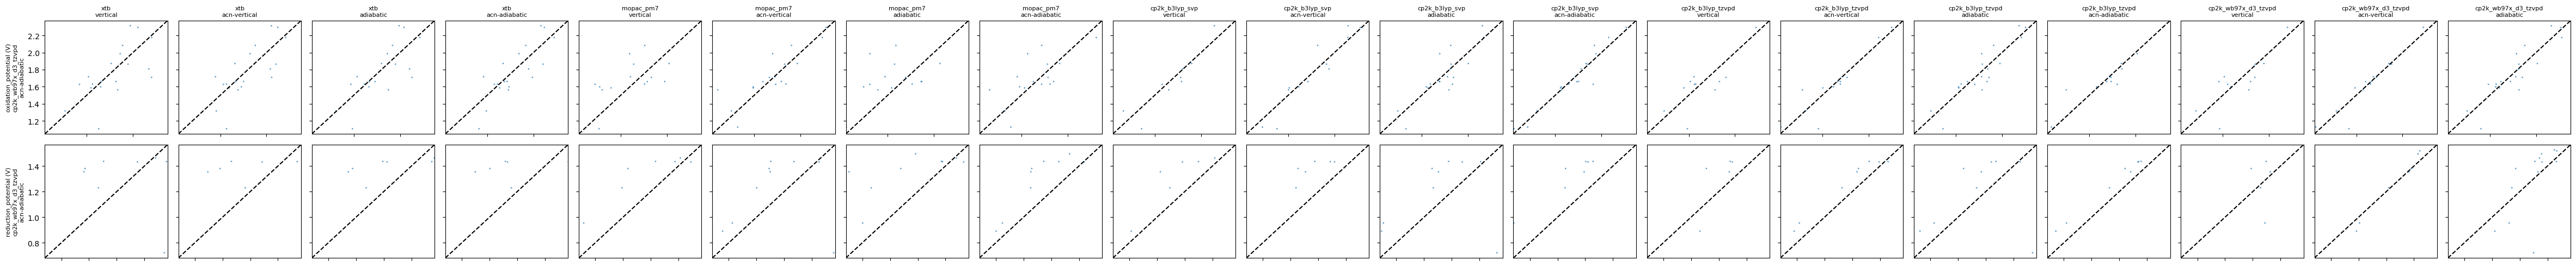

In [12]:
fig, axxs = plt.subplots(len(redox_properties), len(run_order) - 1, figsize=(2.5 * (len(run_order) - 1), 5.), sharey='row', sharex='row')

for prop, axs in zip(redox_properties, axxs):
    target_col = f'{prop}.{run_order[-1]}'
    if target_col not in records.columns:
        print(f'No data for {target_col}')
        continue
    count = np.logical_not(records[target_col].isnull()).sum()
    print(f'Found {count} records for {prop}')
    for level, ax in zip(run_order, axs):
        col = f'{prop}.{level}'
        if col not in records.columns:
            print(f'No data for {col}')
            continue
        
        # Subtract off the average error
        mae = (records[col] - records[target_col]).abs().mean()
        mean_error = (records[col] - records[target_col]).mean()
        mae_corrected = (records[col] - mean_error - records[target_col]).abs().mean()
        print(f'Prop: {prop} - Level: {level} - MAE: {mae:.2f} - MAE,corrected: {mae_corrected:.2f}')
        
        ax.scatter(records[col] - mean_error, records[target_col], s=4, ec='none', alpha=0.7)
        
    # Format the axes
    axs[0].set_ylabel(f'{prop} (V)\n{config_names[-1]}\n{approx_names[-1]}', fontsize=8)
    
# Add y=x
for ax in axxs.flatten():
    ax.set_xlim(ax.get_ylim())
    ax.set_ylim(ax.get_ylim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    ax.set_xticklabels([])
    
# Add the level titles
for ax, level in zip(axxs[0, :], run_order):
    for name in config_names:
        if level.startswith(name):
            conf = name
            appr = level[len(conf)+1:]
    ax.set_title(f'{conf}\n{appr}', fontsize=8)
fig.tight_layout()
fig.savefig('figures/pred-vs-actual-redox.png', dpi=320)

Create a Pareto plot which shows the cumulative runtime vs accuracy

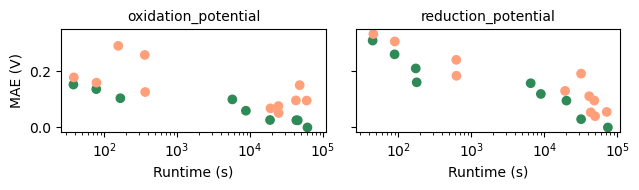

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.), sharex=True, sharey=True)

summary = []
for prop, ax in zip(redox_properties, axs):
    levels = [f'{prop}.{l}' for l in run_order]
    
    # Compute the MAE without the offest
    error_all = (records[levels].values - records[levels[-1]].values[:, None])
    offset_all = np.nanmedian(error_all, axis=0)
    mae_by_level = np.nanmedian(np.abs(error_all - offset_all), axis=0)
    best_so_far = [min(mae_by_level[:i + 1]) for i in range(len(mae_by_level))]
    is_best = np.isclose(mae_by_level, best_so_far)
    
    # Compute the runtime for complete computations
    runtime_all = records[[f'cumulative.{prop}.{l}' for l in run_order]].values
    runtime_all[np.isnan(error_all)] = np.nan
    runtime_by_level = np.nanmedian(runtime_all, axis=0)
    
    ax.scatter(runtime_by_level, mae_by_level, 
               color=['seagreen' if i else 'lightsalmon' for i in is_best])
    
    summary.append(pd.DataFrame({
        'property': [prop] * len(levels),
        'level': run_order,
        'runtime': runtime_by_level,
        'improved': is_best,
        'error': mae_by_level,
    }))

    # Prettify
    ax.set_xlabel('Runtime (s)')
    ax.set_title(prop, fontsize=10)
    ax.set_xscale('log')

axs[0].set_ylabel('MAE (V)')
summary = pd.concat(summary)

fig.tight_layout()
fig.savefig('figures/recipe-pareto-plot-redox.png', dpi=320)

In [24]:
summary.to_csv('runtime-vs-performance-summary.csv', index=False)

Save a copy of the dataset with the columns in a reasonable order

In [14]:
sorted_cols = sorted(records.columns, key=lambda x: (x.count("."), x))
print(f'Displaying columns: {",".join(sorted_cols[:6])},...')

Displaying columns: key,n_atoms,smiles,source,oxidation_potential.cp2k_b3lyp_svp-acn-adiabatic,oxidation_potential.cp2k_b3lyp_svp-acn-vertical,...


In [15]:
records[sorted_cols].to_csv(f'datasets/{"-".join(to_read)}_consolidated.csv.gz', index=False)